<a href="https://colab.research.google.com/github/VimalMollyn/ED6001-Term-Project/blob/colab/Evaluation/1.%20Baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install bm4d
!wget https://raw.githubusercontent.com/VimalMollyn/ED6001-Term-Project/colab/Preprocessing/test.csv
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 4.7 MB 32.5 MB/s 
--2021-11-29 14:35:18--  https://raw.githubusercontent.com/VimalMollyn/ED6001-Term-Project/colab/Preprocessing/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337 [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]     337  --.-KB/s    in 0s      

2021-11-29 14:35:18 (13.2 MB/s) - ‘test.csv’ saved [337/337]

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from bm4d import bm4d
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
import pickle

In [2]:
path_to_data = Path('/content/drive/MyDrive/ED6001_MIA_Term_Project/data/')
path_to_noisy = Path('/content/drive/MyDrive/ED6001_MIA_Term_Project/noisy/')
test_set = pd.read_csv('test.csv')

In [8]:
results = {
    'PSNR_noised': [],
    'PSNR_BM4D': [],
    'PSNR_NLMeans': [],
}

for f in test_set['filepath']:
    img = nib.load(path_to_data / f).get_fdata().copy(order='C')
    img_noised = nib.load(path_to_noisy / f).get_fdata().copy(order='C')

    max_val = max(img.max(), img_noised.max())
    img = img[:, :, (img.shape[2]//2 - 3):(img.shape[2]//2 + 3)] / max_val
    img_noised = img_noised[:, :, (img_noised.shape[2]//2 - 3):(img_noised.shape[2]//2 + 3)] / max_val

    sigma_est = np.mean(estimate_sigma(img_noised))
    img_denoised_bm4d = bm4d(img_noised, sigma_est)
    img_denoised_nlmeans = denoise_nl_means(img_noised, h=sigma_est, sigma=sigma_est, fast_mode=True)

    results['PSNR_noised'].append(peak_signal_noise_ratio(img_noised, img))
    results['PSNR_BM4D'].append(peak_signal_noise_ratio(img_denoised_bm4d, img))
    results['PSNR_NLMeans'].append(peak_signal_noise_ratio(img_denoised_nlmeans, img))

In [9]:
with open('/content/drive/MyDrive/ED6001_MIA_Term_Project/results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
f = test_set['filepath'].iloc[0]
img = nib.load(path_to_data / f).get_fdata().copy(order='C')
img_noised = nib.load(path_to_noisy / f).get_fdata().copy(order='C')

max_val = max(img.max(), img_noised.max())
img = img[:, :, (img.shape[2]//2 - 3):(img.shape[2]//2 + 3)] / max_val
img_noised = img_noised[:, :, (img_noised.shape[2]//2 - 3):(img_noised.shape[2]//2 + 3)] / max_val

sigma_est = np.mean(estimate_sigma(img_noised))
%time img_denoised_bm4d = bm4d(img_noised, sigma_est)
%time img_denoised_nlmeans = denoise_nl_means(img_noised, h=sigma_est, sigma=sigma_est, fast_mode=True)

Text(0.5, 1.0, 'Denoised with NLM')

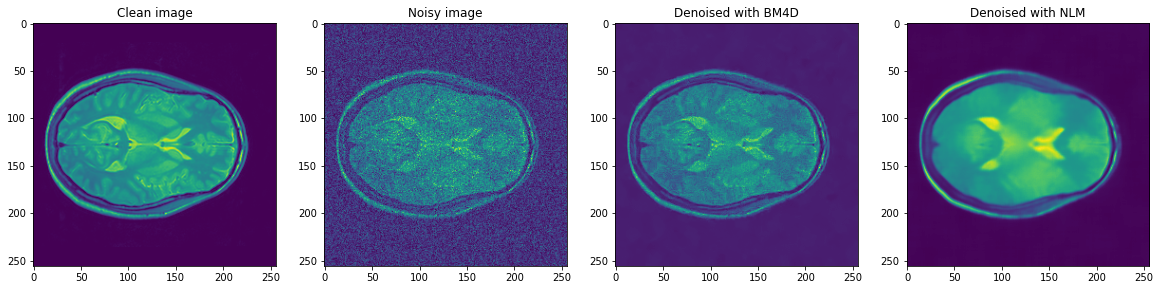

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(20,6))

ax[0].imshow(img[:, :, 0])
ax[0].set_title('Clean image')

ax[1].imshow(img_noised[:, :, 0])
ax[1].set_title('Noisy image')

ax[2].imshow(img_denoised_bm4d[:, :, 0])
ax[2].set_title('Denoised with BM4D')

ax[3].imshow(img_denoised_nlmeans[:, :, 0])
ax[3].set_title('Denoised with NLM')


# plt.savefig('/content/drive/MyDrive/ED6001_MIA_Term_Project/results_1.png')

In [8]:
with open('/content/drive/MyDrive/ED6001_MIA_Term_Project/results.pkl', 'rb') as f:
    results = pickle.load(f)
results = pd.DataFrame(results)
results.columns = ['Noisy', 'Denoised with BM4D', 'Denoised with NLM']

In [9]:
results.to_csv('/content/drive/MyDrive/ED6001_MIA_Term_Project/results.csv', index=False)